# Algorytmy genetyczne

Przykład z **AI for Beginners**

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## Problem 1: Sprawiedliwy podział skarbu

**Problem**:
Dwoje ludzi znalazło skarb składający się z wielu diamentów o różnych rozmiarach (a zatem i wartości). Muszą podzielićskarb na dwie części tak, by różnica w wartościach tych części była równa 0 (lub minimalna).

**Formalna definicja**:
Mamy zbiór liczb $S$. Musimy podzielić go na dwa podzbiory $S_1$ i $S_2$, tak by $$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$ and $S_1\cup S_2=S$, $S_1\cap S_2=\emptyset$.

Po pierwsze zdefiniujmy $S$:

In [2]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[9868 8413 4642 3319 5100 3428 5311 8090 2066 5302 6221 3398 8950 3513
 4261  885 2390 8952 6146 7078 9980 5789 5775 8025 4670 8099 8970 5655
 9199 3194 7676 6177 4345 1332 1536 5567 4765 8468 7454  953 4399 4424
 8504 1670  876 6301 5051 1889 5824 9282 8934 9251 2201 2295 6071 6268
 9349 9498 2400 3066 2535 3931 8642  962 7374 4158 4017 8450 8226  974
 7702  200 2432 7116 9708 5089 8861 7976 4046 4909 5936 4727 8523 6159
 3700 9023 1660  922 5266 1672 6149 8438 4432 2425 7358 2678 2552 4328
  335 5781 7046 4322  369 1862  994 3776 2610 9850 4003 2630 9170 6045
 1815 9184 5417 9114 8958 6522 9196 2216 9959 3518 6238 7883 2174 9896
 3885 6890 7829 3967 5358 7654 8615 7369  104 9146 1651 2575 8693  737
 4240 4568 1692 1008 5697 6440 6331 9122  912 7206 9039 1878  787 4375
 5377 5558 9269 7137 6551 3073 3818 4797  628 8006 5187 1110 6961 1039
 1141 8198 7763 4700 7506 8726 8959 9256 3993 4799 5036 2572 9863 8755
 9848 7703 4940 5788 6259 8623 9763 8187 9555 1370 3890 8664 9870 9671
 5657 

Zakodujmy każde możliwe rozwiązanie problemu za pomocą binarnego wektora $B\in\{0,1\}^N$, w którym numer na $i$-tej pozycji pokazuje do któego z podzbiorów ($S_1$ albo $S_2$) $i$-ty numer z oryginalnego zbioru $S$ należy. Funkcja `generate` wygeneruje takie losowe binarne wektory.

In [3]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1
 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0
 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1
 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0
 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1]


Zdefiniujmy funkcję `fit` która oblicza "koszt" rozwiązania. Kosztem rozwiązania będzie różnica pomiędzy sumami (wartościami) podzbiorów $S_1$ i $S_2$:

In [4]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

158481

Teraz musimy zdefiniować funkcje mutacji i krzyżowania:
* Jako funkcję mutacji wybierzemy jeden losowy bit i zanegujemy go (zmienimy z 0 na 1 i na odwrót)
* Jako funkcję krzyżowania, weźmiemy pewne bity z jednego wektora i niektóre bity z innego. Użyjemy tej samej funkcji `generate` by losowo wybrać, które bity wziąć z którego wektora.

In [5]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

Stwórzmy początkową populację rozwiązań $P$ o rozmiarze `pop_size`:

In [6]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

Czas na główną funkcję ewolucyjną. `n` to liczba kroków ewolucyjnych do przejścia. W każdym kroku:
* Z prawdopodobieństwem równym 30% wykonamy mutację, i zamienimy element z najgorszą wartością funkcji `fit` przez zmutowany element
* Z prawdopodobieństwem równym 70% wykonamy krzyżowanie
Funkcja zwraca najlepsze rozwiązanie (genotyp odpowiadający najlepszemu rozwiązaniu), i historię najmniejszej wartości funkcji kosztu w populacji w każdej iteracji.

In [7]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1
 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0
 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0
 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1
 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0] 45


Zauważ jak mocno ograniczyliśmy wartość funkcji kosztu.

Zobaczmy wykres funkcji `fit` dla całej populacji na przestrzeni całego procesu ewolucyjnego.

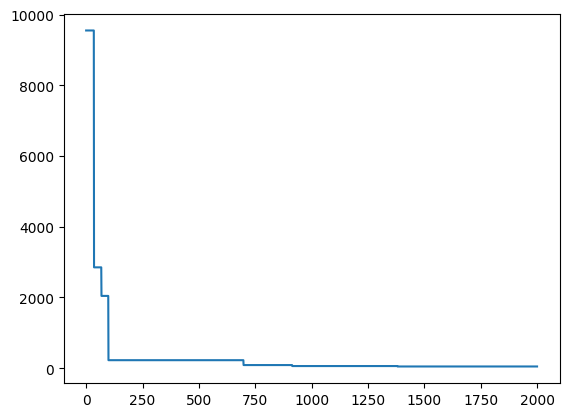

In [8]:
plt.plot(hist)
plt.show()

## Problem 2: N Queens Problem

**Problem**:
Musimy umiejscowić $N$ królowych na szachownicy o rozmiarze $N\times N$ tak by nie atakowały siebie nawzajem.

Po pierwsze można rozwiązać ten problem nie używając algorytmu genetycznego tylko wykonując pełne przeszukanie. Możemy reprezentować stan szachownicy za pomocą listy $L$, gdzie $i$-ty numer na liście to horyzontalna pozycja królowej w $i$-tym wierszu. Oczywistym jest że każdej rozwiązanie będzie miało tylko jedną królową w wierszu i każdy wiersz będzie miał królową.

Naszym celem będzie znalezienie pierwszego rozwiązania, po którym skończymy przeszukanie.

In [9]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False

nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

Teraz sprawdźmy jak dużo czasu zajmuje znalezienie rozwiązania dla problemu 20 królowych:

In [10]:
%timeit nqueens([],20,False)

3.77 s ± 1.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Teraz rozwiążmy ten sam problem używając algorytmu genetycznego. Rozwiązanie inspirowane jest [tym wpisem](https://kushalvyas.github.io/gen_8Q.html).

Każde rozwiązanie będzie reprezentowane przez tę samą listę o długości $N$, a jako funkcję `fit` przyjmiemy liczbę królowych które się wzajemnie atakują:

In [11]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

Z racji, że obliczanie funkcji kosztu jest czasochłonne, przechowujmy każde rozwiązanie w populacji razem z jej wartością. Stwórzmy populację początkową:

In [12]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([3, 2, 5, 4, 6, 1, 7, 8]), 9),
 (array([2, 5, 8, 3, 7, 4, 6, 1]), 2),
 (array([4, 8, 6, 5, 3, 1, 7, 2]), 3),
 (array([6, 3, 1, 4, 2, 8, 7, 5]), 4),
 (array([7, 3, 2, 8, 5, 6, 4, 1]), 3)]

Zdefiniujmy mutację i krzyżowanie. Mutacją będzie zamiany wartości w losowym miejscu na losową. Krzyżowanie będzie kombinacją dwóch genetypów poprzez przerywanie ich w losowym miejscu i konkatenację (łączenie) dwóch powstałych części pochodzących z różnych genotypów.

**Zadanie 4** Zdefiniuj mutację i krzyżowanie zgodnie z powyższym opisami

In [13]:
def mutate(G):
    mutated_G = G.copy()
    index = random.randint(0, len(G)-1)
    mutated_G[index] = random.randint(1, len(G))
    return mutated_G

def xover(G1, G2):
    crossover_point = random.randint(0, len(G1))
    offspring = np.concatenate((G1[:crossover_point], G2[crossover_point:]))
    return offspring

Wspomożemy proces selekcji genów poprzez selekcję większej liczby genów z lepszą wartością funkcji kosztu. Prawdopodobieństwo wybrania danego genotypu będzie zależeć od jego funkcji kosztu:

In [14]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # maksymalna funkcja kosztu
    z = [mf-x[1] for x in P]
    tf = sum(z) # całkowita funkcja kosztu
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # maksymalna funkcja kosztu
    z = [mf-x[1] for x in P]
    tf = sum(z) # całkowita funkcja kosztu
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

Teraz zdefiniujmy główną pętlę ewolucyjną. Nieco zmienimy logikę rozumowania w porównaniu do poprzedniego przykładu. Będziemy wykonywać iterację dopóki nie osiągniemy najlepszego możliwego rozwiązania (funkcja kosztu=0), w każdym kroku będziemy brać aktualne pokolenie i produkować nowe o tym samym rozmiarze. Użyjemy do tego funkcji `nxgeneration` o następującyh krokach:

1. Odrzuć najbardziej niedopasowane rozwiązania - wykonuje to funkcja `discard_unfit`
2. Dodaj trochę losowych rozwiązań do populacji
3. Uzupełnij nową generację do rozmiaru `gen_size` stosując następujące kroki dla każdego nowego genotypu:
    - wybierz dwa losowe genotypy, z prawdopodobieństwem proporcjonalnym do wartości funkcji kosztu
    - wykonaj krzyżowanie
    - wykonaj mutację z prawdopodobieństwem `mutation_prob`

In [15]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n= mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
    return new_gen

def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

Generation 0, fit=1
Generation 1, fit=1
Generation 2, fit=1
Generation 3, fit=1
Generation 4, fit=1
Generation 5, fit=1


(array([6, 4, 7, 1, 3, 5, 2, 8]), 0)

**Zadanie 5**

Uzupełnij puste miejsca (...) w powyższych funkcjach w wywołanie odpowiednich funkcji:

    1. fit(n)
    2. nxgeneration(P)
    3. discard_unfit(P)
    4. mutate(n)
    5. choose_rand(P)

Ciekawe że w większości przypadków osiągamy rozwiązanie dość szybko, ale w niektórych rzadkich przypadkach optymalizacja osiąga lokalne minimum i proces utyka w nim na długi czas. Należy brać to pod uwagę podczas pomiaru średniego czasu: podczas gdy w większości przypadków algorytmy genetyczne będą znacznie szybsze niż pełne przeszukanie, czasem mogą być wolniejsze. By obejść ten problem, sens ma ograniczenie liczby rozważanych pokoleń, a jeśli nie możemy znaleźć optymalnego rozwiązania - zaczynamy od zera.

In [ ]:
%timeit genetic(10)

Streaming output truncated to the last 5000 lines.
Generation 307, fit=1
Generation 308, fit=1
Generation 309, fit=1
Generation 310, fit=1
Generation 311, fit=1
Generation 312, fit=1
Generation 313, fit=1
Generation 314, fit=1
Generation 315, fit=1
Generation 316, fit=1
Generation 317, fit=1
Generation 318, fit=1
Generation 319, fit=1
Generation 320, fit=1
Generation 321, fit=1
Generation 322, fit=1
Generation 323, fit=1
Generation 324, fit=1
Generation 325, fit=1
Generation 326, fit=1
Generation 327, fit=1
Generation 328, fit=1
Generation 329, fit=1
Generation 330, fit=1
Generation 331, fit=1
Generation 332, fit=1
Generation 333, fit=1
Generation 334, fit=1
Generation 335, fit=1
Generation 336, fit=1
Generation 337, fit=1
Generation 338, fit=1
Generation 339, fit=1
Generation 340, fit=1
Generation 341, fit=1
Generation 342, fit=1
Generation 343, fit=1
Generation 344, fit=1
Generation 345, fit=1
Generation 346, fit=1
Generation 347, fit=1
Generation 348, fit=1
Generation 349, fit=1
Gen